In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,9)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns

In [2]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\HUDaily.csv', index_col=0, parse_dates=True)

df.head()

,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
Datetime,,,,,,,,
2010-02-02,101.613979,139.386646,0.102313,4.377917,3.256250,1005.291667,92.458333,5.823750
2010-02-03,98.845000,182.338125,0.375250,1.380000,0.423750,1007.625000,93.333333,2.943750
2010-02-04,97.897604,152.264583,0.428312,5.105833,4.458333,1004.333333,95.666667,4.350000
2010-02-05,87.718333,134.719208,0.377042,6.210417,5.026250,999.625000,92.333333,3.540417
2010-02-06,55.565125,135.339687,0.089542,3.039167,2.714167,1015.208333,97.750000,3.332917


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
values = df.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [5]:
scaled[:1]

array([[0.94544987, 0.46191134, 0.0966523 , 0.32327854, 0.39756619,
        0.43721973, 0.839254  , 0.41737377]])

In [6]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.945450,0.461911,0.096652,0.323279,0.397566,0.437220,0.839254,0.417374,0.916685
2,0.916685,0.604248,0.354490,0.232088,0.286674,0.468610,0.857904,0.177007,0.906843
3,0.906843,0.504587,0.404617,0.345420,0.444628,0.424327,0.907638,0.294373,0.801096
4,0.801096,0.446444,0.356183,0.379019,0.466861,0.360987,0.836590,0.226805,0.467074
5,0.467074,0.448500,0.084588,0.282557,0.376344,0.570628,0.952043,0.209487,0.439386


In [7]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 8
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2920, 1, 8) (2920,) (1490, 1, 8) (1490,)


In [8]:
# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [9]:
# fit network
history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
92/92 - 2s - loss: 0.1019 - val_loss: 0.0248 - 2s/epoch - 19ms/step
Epoch 2/50
92/92 - 0s - loss: 0.0221 - val_loss: 0.0228 - 157ms/epoch - 2ms/step
Epoch 3/50
92/92 - 0s - loss: 0.0205 - val_loss: 0.0217 - 240ms/epoch - 3ms/step
Epoch 4/50
92/92 - 0s - loss: 0.0197 - val_loss: 0.0210 - 347ms/epoch - 4ms/step
Epoch 5/50
92/92 - 0s - loss: 0.0193 - val_loss: 0.0206 - 355ms/epoch - 4ms/step
Epoch 6/50
92/92 - 1s - loss: 0.0190 - val_loss: 0.0202 - 580ms/epoch - 6ms/step
Epoch 7/50
92/92 - 0s - loss: 0.0189 - val_loss: 0.0199 - 290ms/epoch - 3ms/step
Epoch 8/50
92/92 - 0s - loss: 0.0187 - val_loss: 0.0197 - 315ms/epoch - 3ms/step
Epoch 9/50
92/92 - 0s - loss: 0.0186 - val_loss: 0.0195 - 207ms/epoch - 2ms/step
Epoch 10/50
92/92 - 0s - loss: 0.0185 - val_loss: 0.0193 - 184ms/epoch - 2ms/step
Epoch 11/50
92/92 - 0s - loss: 0.0184 - val_loss: 0.0191 - 198ms/epoch - 2ms/step
Epoch 12/50
92/92 - 0s - loss: 0.0183 - val_loss: 0.0189 - 187ms/epoch - 2ms/step
Epoch 13/50
92/92 - 0s - lo

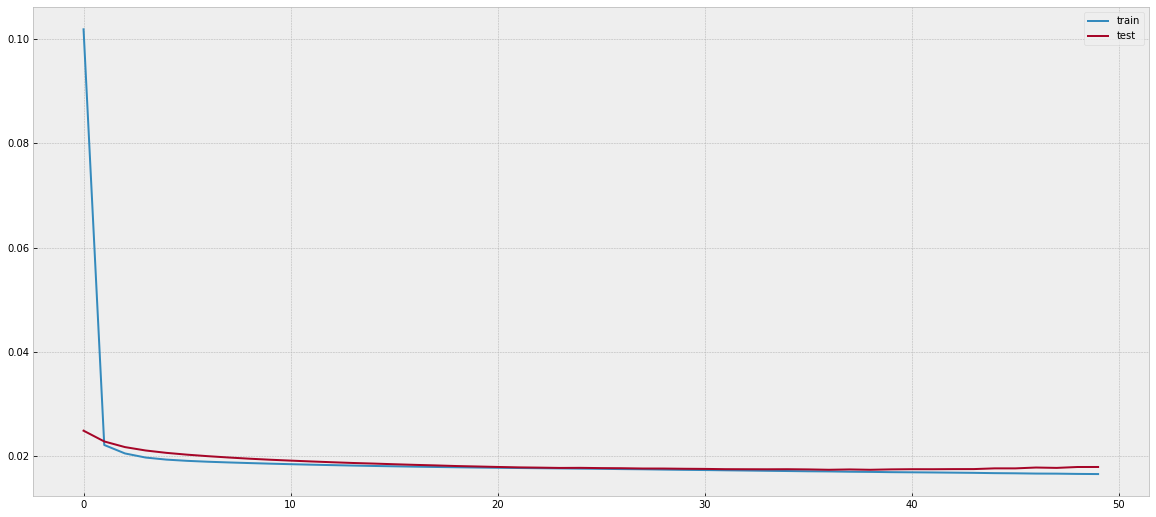

In [10]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import *

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
mse = mean_squared_error(test_y, yhat)
mae = mean_absolute_error(test_y, yhat)
r2 = r2_score(test_y, yhat)


# rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# mse = mean_squared_error(inv_y, inv_yhat)
# mae = mean_absolute_error(inv_y, inv_yhat)
# r2 = r2_score(inv_y, inv_yhat)

print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

Test RMSE: 0.134
Test MSE: 0.018
Test MAE: 0.105
Test R2: 0.486


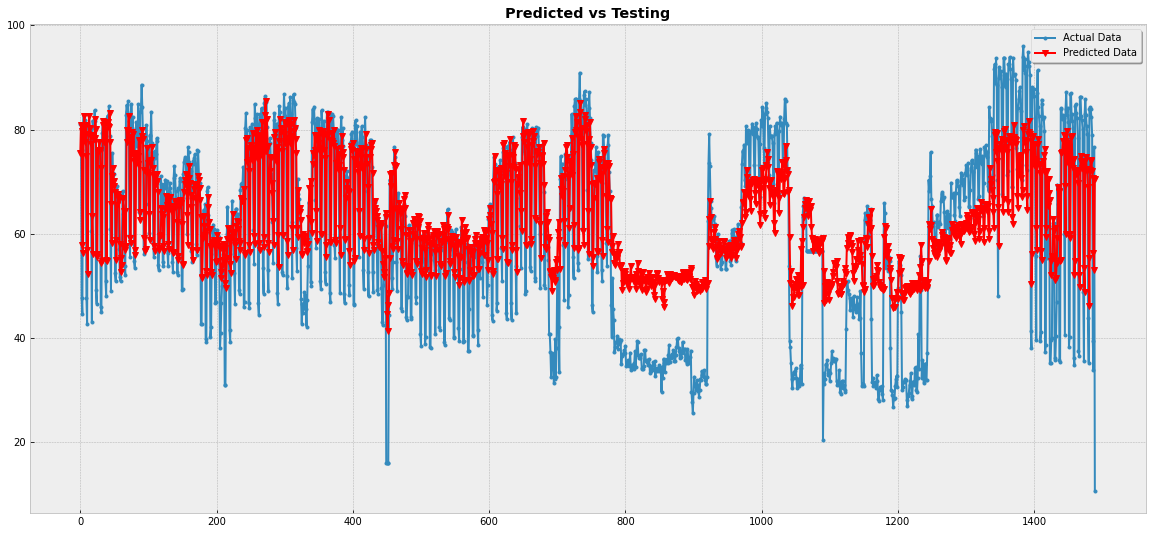

In [12]:
plt.plot(inv_y.flatten(), marker='.', label='Actual Data')
plt.plot(inv_yhat.flatten(), marker='v', color='r', label='Predicted Data')
plt.title('Predicted vs Testing', fontweight='bold')
plt.legend(shadow=True);